In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import quaternion
import trimesh
from PIL import Image
from trimesh import load as load_model, viewer

from scan2cad_rasterizer import Rasterizer

[[435.19   0.   239.9    0.  ]
 [  0.   435.19 179.91   0.  ]
 [  0.     0.     1.     0.  ]
 [  0.     0.     0.     1.  ]]
[[ 0.350874   0.460271  -0.815498   2.202    ]
 [ 0.936203  -0.153559   0.316139   1.49633  ]
 [ 0.0202828 -0.874397  -0.484787   1.39319  ]
 [ 0.         0.         0.         1.       ]]
dict_keys(['trs', 'n_aligned_models', 'aligned_models', 'id_alignment', 'id_scan'])


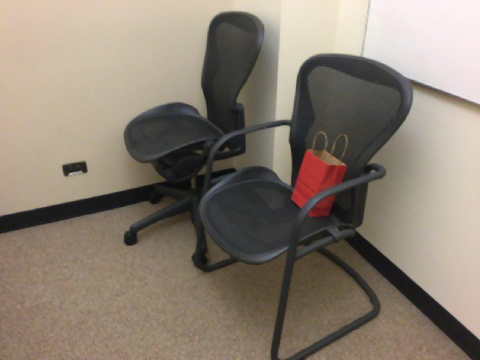

In [2]:
intr_file = '../samples/scannet_0470_00_intr.txt'
pose_file = '../samples/scannet_0470_00_0_pose.txt'
img_file = '../samples/scannet_0470_00_0.jpg'
data_file = '../samples/annot.json'

with open(intr_file) as f:
    intr = np.array([
        [float(w) for w in l.strip().split()]
        for l in f
    ])

with open(pose_file) as f:
    pose = np.array([
        [float(w) for w in l.strip().split()]
        for l in f
    ])

with open(data_file) as f:
    annot = json.load(f)[0]

img = Image.open(img_file)

print(intr)
print(pose)
print(annot.keys())

img

In [3]:
def make_M_from_tqs(t: list, q: list, s: list, center=None) -> np.ndarray:
    if not isinstance(q, np.quaternion):
        q = np.quaternion(q[0], q[1], q[2], q[3])
    T = np.eye(4)
    T[0:3, 3] = t
    R = np.eye(4)
    R[0:3, 0:3] = quaternion.as_rotation_matrix(q)
    S = np.eye(4)
    S[0:3, 0:3] = np.diag(s)

    C = np.eye(4)
    if center is not None:
        C[0:3, 3] = center

    M = T.dot(R).dot(S).dot(C)
    return M

to_scannet = np.linalg.inv(make_M_from_tqs(
    annot['trs']['translation'],
    annot['trs']['rotation'],
    annot['trs']['scale']
))
to_cam = np.linalg.inv(pose)
models = []
for model in annot['aligned_models']:
    alignment = make_M_from_tqs(
        model['trs']['translation'],
        model['trs']['rotation'],
        model['trs']['scale']
    )
    # Normally this should include cat ids
    with open('../samples/Meshes/{}/models/model_normalized.obj'.format(model['id_cad'])) as f:
        model = load_model(file_obj=f, file_type='obj', force='mesh')

    model.apply_transform(to_cam @ to_scannet @ alignment)
    models.append(model)

with open('../samples/Meshes/camera.obj') as f:
    camera = load_model(file_obj=f, file_type='obj', force='mesh')
    camera.apply_scale(.5)
scene = trimesh.Scene([m.copy() for m in models])
scene.apply_transform(np.array([
            [1, 0, 0, 0],
            [0, np.cos(np.pi), -np.sin(np.pi), 0],
            [0, np.sin(np.pi), np.cos(np.pi), 0],
            [0, 0, 0, 1]
        ])
)
scene.add_geometry(camera)
viewer.notebook.scene_to_notebook(scene)

concatenating texture: may result in visual artifacts
concatenating texture: may result in visual artifacts
concatenating texture: may result in visual artifacts
concatenating texture: may result in visual artifacts
concatenating texture: may result in visual artifacts
unable to load materials from: model_normalized.mtl
specified material (material_52_24)  not loaded!
specified material (material_37_24)  not loaded!
specified material (material_27_24)  not loaded!
specified material (material_47_24)  not loaded!
specified material (material_26_24)  not loaded!
specified material (material_24_24)  not loaded!
specified material (material_15_24)  not loaded!
specified material (material_6_24)  not loaded!
specified material (material_1_24)  not loaded!


In [4]:
raster = Rasterizer(intr[0, 0], intr[1, 1], intr[0, 2], intr[1, 2], False, True)
for i, model in enumerate(models, start=1):
    # print(model)
    print(model.face_normals.shape, model.faces.shape)
    raster.add_model(
        np.asarray(model.faces, dtype=raster.index_dtype),
        np.asarray(model.vertices, dtype=raster.scalar_dtype),
        i,
        np.eye(4),  # dummy argument,
        np.asarray(model.face_normals, raster.scalar_dtype)
    )
raster.rasterize()

# exit(0)

(2680, 3) (2680, 3)
(1752, 3) (1752, 3)
(2276, 3) (2276, 3)
(2276, 3) (2276, 3)
(11748, 3) (11748, 3)
(840, 3) (840, 3)
(9200, 3) (9200, 3)


[0 2 7]


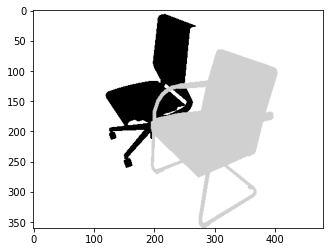

In [5]:
instances = raster.read_idx()
print(np.unique(instances))
plt.imshow(instances, cmap='Greys')

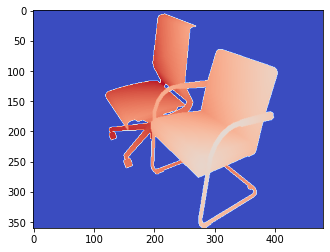

In [6]:
depth = raster.read_depth()
plt.imshow(depth, cmap='coolwarm')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


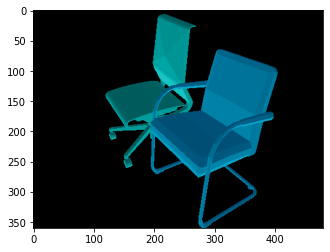

In [17]:
raster.set_colors({7: np.array([0, 0.9, 0.9]), 2: np.array([0, 0.8, 1])})
# raster.set_colors({})
raster.render_colors(0.25)
shaded = raster.read_color()
plt.imshow(shaded)

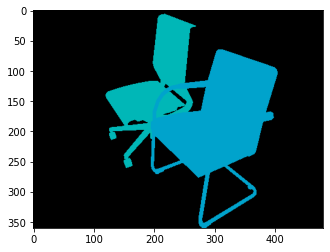

In [20]:
raster.render_colors(0.)
unshaded = raster.read_color()
# Avoid being too bright
plt.imshow(0.8 * unshaded)